In [1]:
import torch
import pandas as pd
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from pathlib import Path

# This cell loads all trained vectors that have been finished/created, as in generate_behavior_rollouts.py

# Set the root directory for persona data (should match PERSONA_ROOT in generate_behavior_rollouts.py)
PERSONA_ROOT = Path("/workspace/persona-data")
STEERING_RUN_ROOT = Path("/workspace/steering_runs_qwen3_layer_30")
TRAINED_LAYER = 30  # default trained layer

def load_trained_vector(dataset: str, layer: int = TRAINED_LAYER):
    """
    Load the trained steering vector for a given dataset and layer.
    Returns a torch.Tensor or None if not found.
    """
    steering_dir = STEERING_RUN_ROOT / dataset
    trained_vector: torch.Tensor | None = None
    vector_path = steering_dir / "steering_vector.pt"
    if vector_path.exists():
        state = torch.load(vector_path, map_location="cpu")
        tensor = state.get("steering_vector")
        if tensor is None:
            raise ValueError(f"steering_vector.pt missing 'steering_vector' key at {vector_path}")
        trained_vector = tensor.float()
        if torch.cuda.is_available():
            trained_vector = trained_vector
        config_path = steering_dir / "steering_config.json"
        if config_path.exists():
            cfg = json.loads(config_path.read_text())
            trained_layer = int(cfg.get("target_layer", -1))
            assert trained_layer == TRAINED_LAYER
        return trained_vector
    return None

# If you have a DataFrame of datasets, use its unique values; otherwise, scan the vector directories
# Fallback: scan for all .pt files in traits_240 and roles_240
datasets = []
trait_dir = PERSONA_ROOT.glob("*/traits_240/vectors/*.pt")
for f in trait_dir:
    model_prefix = f.parts[-4]
    trait = f.stem
    datasets.append(f"{model_prefix}__trait__{trait}")
role_dir = PERSONA_ROOT.glob("qwen-3-32b/roles_240/vectors/*.pt")
for f in role_dir:
    role = f.stem
    datasets.append(f"qwen-3-32b__role__{role}")

trained_vectors = {}
for dataset in datasets:
    vec = load_trained_vector(dataset)
    if vec is not None:
        trained_vectors[dataset] = vec

In [2]:
from tqdm import tqdm

# Build a mapping: {dataset: list[tensor]}, where each list contains activation vectors for all layers (0-31)
all_activation_vectors = {}
default_vecs = torch.load(
    PERSONA_ROOT / "qwen-3-32b" / "roles_240" / "default_vectors.pt", map_location="cpu"
)


def load_activation_vector(dataset: str) -> torch.Tensor | None:
    if "__trait__" in dataset:
        model_prefix, trait = dataset.split("__trait__", 1)
        vec_file = PERSONA_ROOT / f"{model_prefix}/traits_240/vectors/{trait}.pt"
        if not vec_file.exists():
            return None
        data = torch.load(vec_file, map_location="cpu")
        vec = data["pos_neg_50"].float()
        return vec.float()
    elif "__role__" in dataset:
        role = dataset.split("__role__", 1)[1]
        vec_file = PERSONA_ROOT / f"qwen-3-32b/roles_240/vectors/{role}.pt"
        if not vec_file.exists():
            return None
        data = torch.load(vec_file, map_location="cpu")
        vec_pos = data["pos_3"].float()
        vec_contrast = vec_pos - default_vecs["activations"]["default_1"]
        return vec_contrast
    return None


for dataset in tqdm(trained_vectors.keys()):
    layer_to_vec = load_activation_vector(dataset)
    # Build a list of tensors for layers 0-31 (None if missing)
    all_activation_vectors[dataset] = layer_to_vec[:32]
    


100%|██████████| 183/183 [00:03<00:00, 46.79it/s]


In [3]:
from tqdm import trange

# compare trained vector to corresponding activation vector
cosine_sims_by_layer = []
for layer in trange(32):
    cosine_sims = {}
    for dataset in trained_vectors.keys():
        trained_vector = trained_vectors[dataset]
        activation_vector = all_activation_vectors[dataset][layer]
        cosine_sim = cosine_similarity(
            trained_vector.reshape(1, -1),
            activation_vector.reshape(1, -1),
        )[0, 0]
        cosine_sims[dataset] = cosine_sim
    cosine_sims_by_layer.append(cosine_sims)


100%|██████████| 32/32 [00:01<00:00, 27.33it/s]


(32, 183)


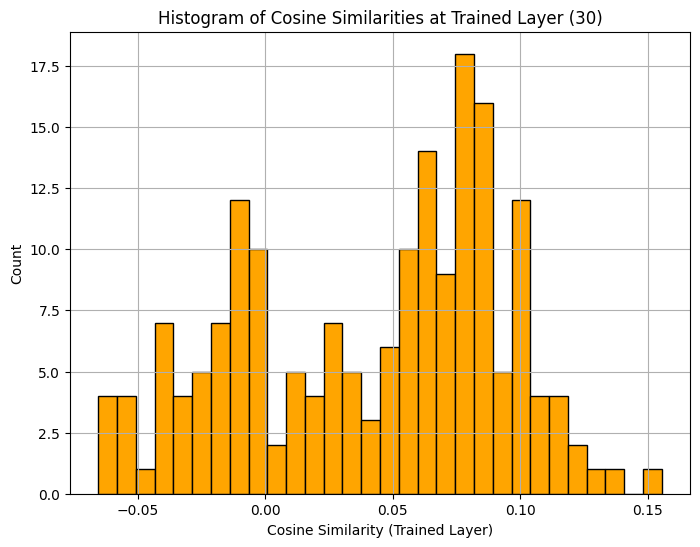

In [4]:
import matplotlib.pyplot as plt
import numpy as np

flattened_cosine_sims_by_layer = np.array(
    [list(layer_dict.values()) for layer_dict in cosine_sims_by_layer]
)
print(flattened_cosine_sims_by_layer.shape)

plt.figure(figsize=(8, 6))
plt.hist(
    flattened_cosine_sims_by_layer[TRAINED_LAYER],
    bins=30,
    color="orange",
    edgecolor="k",
)
plt.xlabel("Cosine Similarity (Trained Layer)")
plt.ylabel("Count")
plt.title(f"Histogram of Cosine Similarities at Trained Layer ({TRAINED_LAYER})")
plt.grid(True)
plt.show()


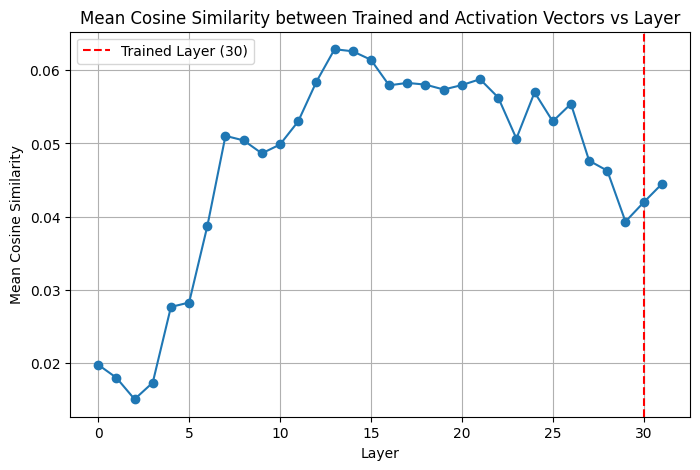

In [5]:

# Compute mean cosine similarity per layer
mean_cosine_sims = [
    np.mean(list(layer_dict.values())) for layer_dict in cosine_sims_by_layer
]

plt.figure(figsize=(8, 5))
plt.axvline(x=TRAINED_LAYER, color="red", linestyle="--", label=f"Trained Layer ({TRAINED_LAYER})")
plt.legend()
plt.plot(range(32), mean_cosine_sims, marker="o")
plt.xlabel("Layer")
plt.ylabel("Mean Cosine Similarity")
plt.title("Mean Cosine Similarity between Trained and Activation Vectors vs Layer")
plt.grid(True)
plt.show()


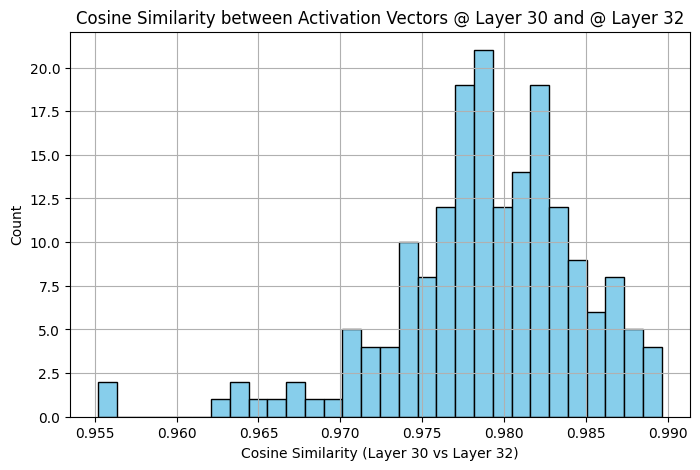

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the layer N to compare with layer 32 (Python index 31)
layer_n = TRAINED_LAYER

cosine_sims_n_vs_32 = []

for dataset in trained_vectors.keys():
    vec_n = all_activation_vectors[dataset][layer_n]
    vec_32 = all_activation_vectors[dataset][31]
    sim = cosine_similarity(
        vec_n.reshape(1, -1), vec_32.reshape(1, -1)
    )[0, 0]
    cosine_sims_n_vs_32.append(sim)

plt.figure(figsize=(8, 5))
plt.hist(cosine_sims_n_vs_32, bins=30, color='skyblue', edgecolor='k')
plt.xlabel(f"Cosine Similarity (Layer {layer_n} vs Layer 32)")
plt.ylabel("Count")
plt.title(f"Cosine Similarity between Activation Vectors @ Layer {layer_n} and @ Layer 32")
plt.grid(True)
plt.show()


/tmp/ipykernel_2025301/4029537470.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


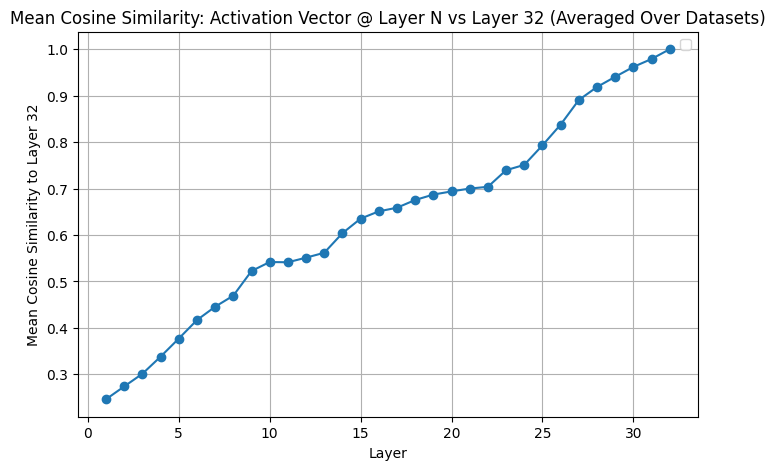

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# For each layer, compute the mean cosine similarity between that layer's activation vector and layer 32's activation vector, averaged over all datasets
num_layers = 32
mean_cosine_sims_vs_32 = []

for layer_idx in range(num_layers):
    sims = []
    for dataset in trained_vectors.keys():
        vec_n = all_activation_vectors[dataset][layer_idx]
        vec_32 = all_activation_vectors[dataset][31]
        sim = cosine_similarity(
            vec_n.reshape(1, -1), vec_32.reshape(1, -1)
        )[0, 0]
        sims.append(sim)
    mean_cosine_sims_vs_32.append(np.mean(sims))

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_layers + 1), mean_cosine_sims_vs_32, marker='o')
plt.xlabel("Layer")
plt.ylabel("Mean Cosine Similarity to Layer 32")
plt.title("Mean Cosine Similarity: Activation Vector @ Layer N vs Layer 32 (Averaged Over Datasets)")
plt.legend()
plt.grid(True)
plt.show()


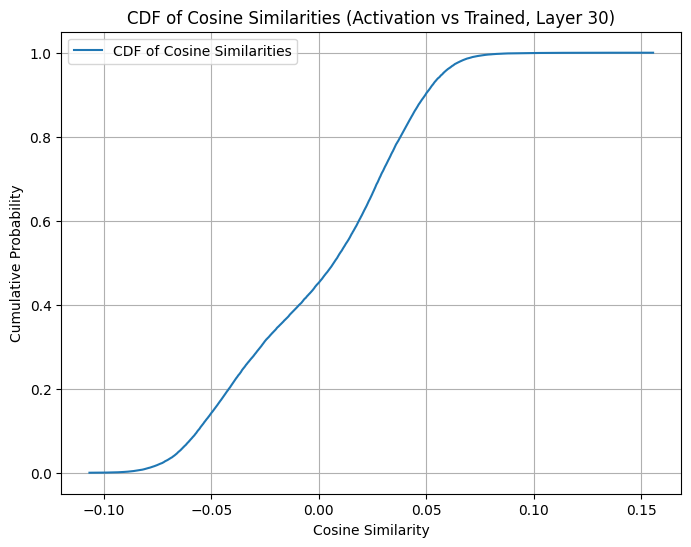

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

activation_vectors_arr = np.stack([
    all_activation_vectors[dataset][TRAINED_LAYER]
    for dataset in trained_vectors.keys()
])
trained_vectors_arr = np.stack([
    trained_vectors[dataset]
    for dataset in trained_vectors.keys()
])
sim_matrix = cosine_similarity(activation_vectors_arr, trained_vectors_arr)

sim_df = pd.DataFrame(
    sim_matrix,
    index=[f"{ds} (activation)" for ds in trained_vectors.keys()],
    columns=[f"{ds} (trained)" for ds in trained_vectors.keys()]
)


# Flatten the similarity matrix to get all pairwise similarities
all_sims = sim_matrix.flatten()

# Plot the CDF
plt.figure(figsize=(8, 6))
sorted_sims = np.sort(all_sims)
cdf = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
plt.plot(sorted_sims, cdf, label="CDF of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Cumulative Probability")
plt.title(f"CDF of Cosine Similarities (Activation vs Trained, Layer {TRAINED_LAYER})")
plt.grid(True)
plt.legend()
plt.show()


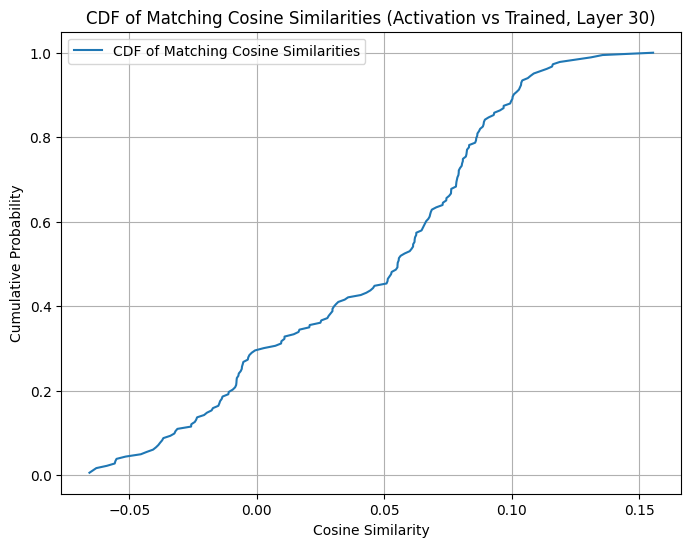

In [9]:
# Plot CDF for only the matching (diagonal) similarities: activation vs trained for the same dataset
matching_sims = np.diag(sim_matrix)

plt.figure(figsize=(8, 6))
sorted_matching_sims = np.sort(matching_sims)
cdf_matching = np.arange(1, len(sorted_matching_sims) + 1) / len(sorted_matching_sims)
plt.plot(sorted_matching_sims, cdf_matching, label="CDF of Matching Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Cumulative Probability")
plt.title(f"CDF of Matching Cosine Similarities (Activation vs Trained, Layer {TRAINED_LAYER})")
plt.grid(True)
plt.legend()
plt.show()


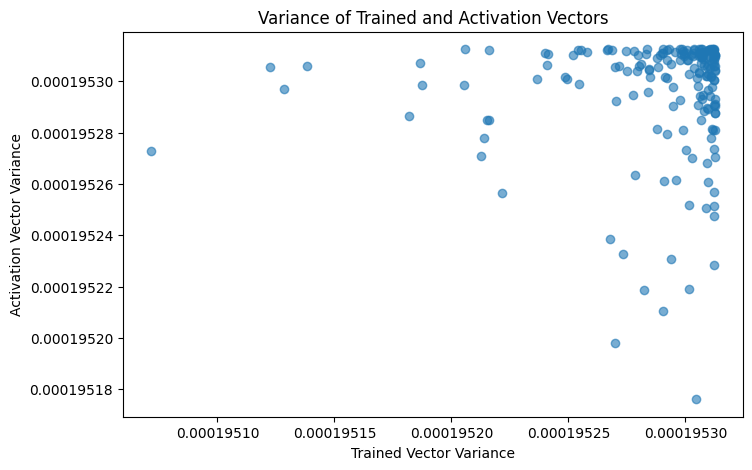

In [10]:
trained_vectors_arr_normalized = trained_vectors_arr / np.linalg.norm(trained_vectors_arr, axis=-1, keepdims=True)
activation_vectors_arr_normalized = activation_vectors_arr / np.linalg.norm(activation_vectors_arr, axis=-1, keepdims=True)
trained_var = np.var(trained_vectors_arr_normalized, axis=-1)
activation_var = np.var(activation_vectors_arr_normalized, axis=-1)

plt.figure(figsize=(8, 5))
plt.scatter(trained_var, activation_var, alpha=0.6)
plt.xlabel("Trained Vector Variance")
plt.ylabel("Activation Vector Variance")
plt.title("Variance of Trained and Activation Vectors")
plt.show()

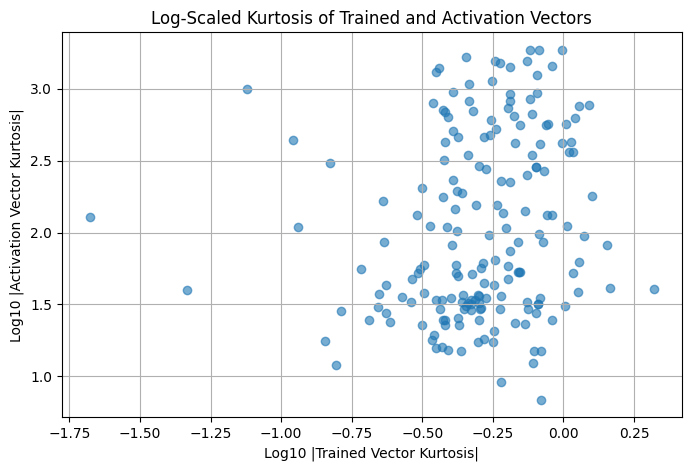

In [11]:
from scipy.stats import kurtosis

# Compute kurtosis for each vector (across dimensions)
trained_kurtosis = kurtosis(trained_vectors_arr_normalized, axis=-1, fisher=True, bias=False)
activation_kurtosis = kurtosis(activation_vectors_arr_normalized, axis=-1, fisher=True, bias=False)

# Take log10 of the absolute value of kurtosis plus a small epsilon to avoid log(0)
epsilon = 1e-8
trained_kurtosis_log = np.log10(np.abs(trained_kurtosis) + epsilon)
activation_kurtosis_log = np.log10(np.abs(activation_kurtosis) + epsilon)

plt.figure(figsize=(8, 5))
plt.scatter(trained_kurtosis_log, activation_kurtosis_log, alpha=0.6)
plt.xlabel("Log10 |Trained Vector Kurtosis|")
plt.ylabel("Log10 |Activation Vector Kurtosis|")
plt.title("Log-Scaled Kurtosis of Trained and Activation Vectors")
plt.grid(True)
plt.show()


Text(0, 0.5, 'Activation Vector Mean')

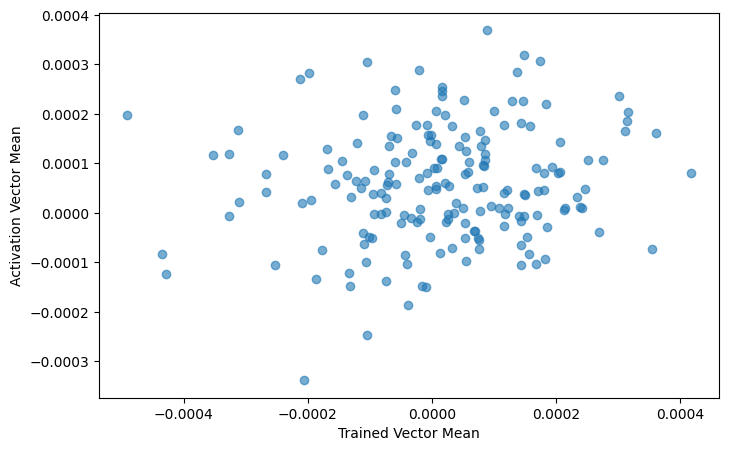

In [12]:
trained_mean = np.mean(trained_vectors_arr_normalized, axis=-1)
activation_mean = np.mean(activation_vectors_arr_normalized, axis=-1)

plt.figure(figsize=(8, 5))
plt.scatter(trained_mean, activation_mean, alpha=0.6)
plt.xlabel("Trained Vector Mean")
plt.ylabel("Activation Vector Mean")

Best p: 0.515
Original cosine sim: mean=0.042, std=0.051
Flattened cosine sim: mean=0.062, std=0.023


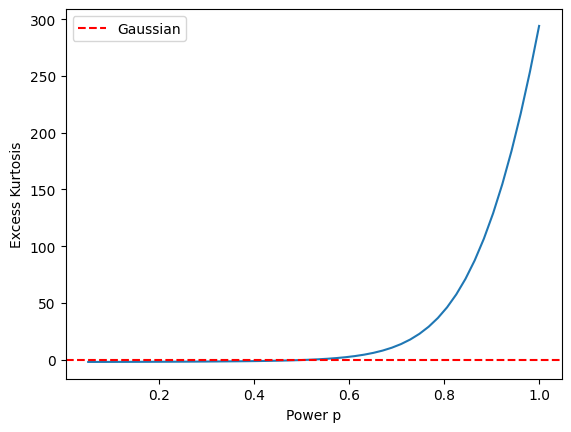

In [13]:
def flatten_kurtosis(vectors, target_kurtosis=0.0, p_range=(0.05, 1.0), n_samples=50):
    """
    Find power transform that gives target excess kurtosis.
    
    Args:
        vectors: (n_vectors, n_dims) array of vectors
        target_kurtosis: target excess kurtosis (0 = Gaussian)
        p_range: range of powers to search
        n_samples: number of p values to try
    
    Returns:
        transformed_vectors: vectors with ~Gaussian kurtosis
        best_p: power that achieved target kurtosis
        kurtosis_curve: (p_values, kurtosis_values) for plotting
    """
    p_values = np.linspace(p_range[0], p_range[1], n_samples)
    kurtosis_values = []
    
    for p in p_values:
        # Apply power transform
        transformed = np.sign(vectors) * np.abs(vectors) ** p
        # L2 normalize
        transformed = transformed / np.linalg.norm(transformed, axis=1, keepdims=True)
        # Compute mean excess kurtosis across vectors
        kurt = np.mean([kurtosis(v, fisher=True) for v in transformed])
        kurtosis_values.append(kurt)
    
    # Find p closest to target
    kurtosis_values = np.array(kurtosis_values)
    best_idx = np.argmin(np.abs(kurtosis_values - target_kurtosis))
    best_p = p_values[best_idx]
    
    # Apply best transform
    transformed = np.sign(vectors) * np.abs(vectors) ** best_p
    transformed = transformed / np.linalg.norm(transformed, axis=1, keepdims=True)
    
    return transformed, best_p, (p_values, kurtosis_values)

# Usage:
# activation_vecs: (n_traits, 5120) array of activation vectors
# trained_vecs: (n_traits, 5120) array of trained vectors

# Flatten activation vectors to Gaussian kurtosis
flattened_act, best_p, (ps, kurts) = flatten_kurtosis(activation_vectors_arr_normalized)

# Compute cosine similarities before and after
cos_sim_original = np.sum(activation_vectors_arr_normalized * trained_vectors_arr_normalized, axis=1)  # already normalized
cos_sim_flattened = np.sum(flattened_act * trained_vectors_arr_normalized, axis=1)

print(f"Best p: {best_p:.3f}")
print(f"Original cosine sim: mean={cos_sim_original.mean():.3f}, std={cos_sim_original.std():.3f}")
print(f"Flattened cosine sim: mean={cos_sim_flattened.mean():.3f}, std={cos_sim_flattened.std():.3f}")

# Plot kurtosis vs p
plt.plot(ps, kurts)
plt.axhline(y=0, color='r', linestyle='--', label='Gaussian')
plt.xlabel('Power p')
plt.ylabel('Excess Kurtosis')
plt.legend()
plt.show()


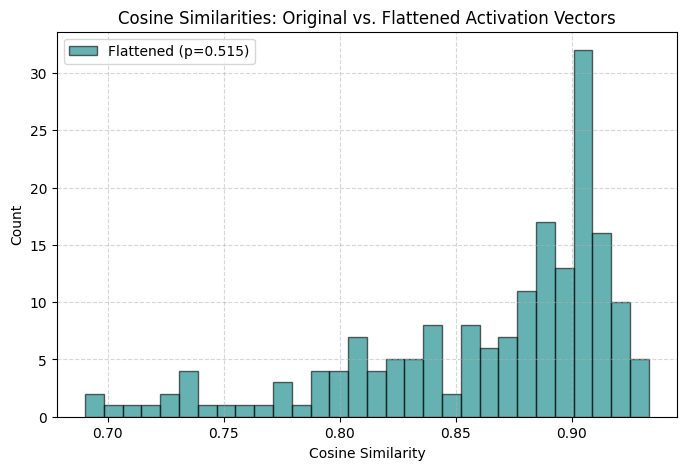

In [14]:
cosine_sim_after_p = np.sum(flattened_act * activation_vectors_arr_normalized, axis=1) / (np.linalg.norm(flattened_act, axis=1) * np.linalg.norm(activation_vectors_arr_normalized, axis=1))
plt.figure(figsize=(8, 5))
plt.hist(cosine_sim_after_p, bins=30, alpha=0.6, label=f'Flattened (p={best_p:.3f})', color='teal', edgecolor='black')
plt.title('Cosine Similarities: Original vs. Flattened Activation Vectors')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


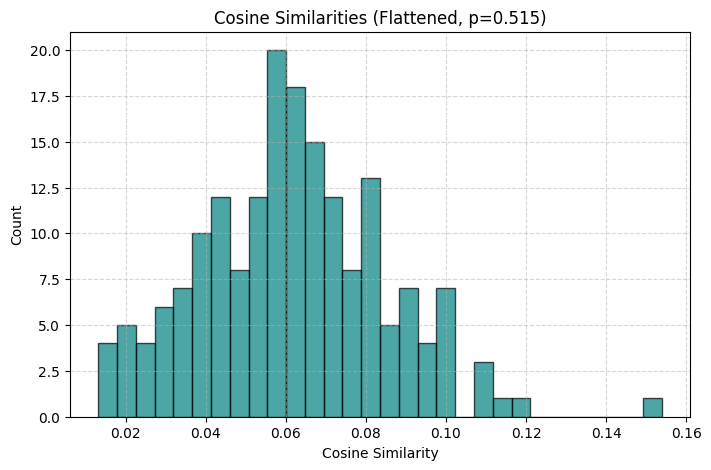

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(cos_sim_flattened, bins=30, alpha=0.7, color='teal', edgecolor='black')
plt.title(f'Cosine Similarities (Flattened, p={best_p:.3f})')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Mean sparsity (|x| < 1e-04):
  Activation vectors: 0.0087
  Trained vectors:    0.0059


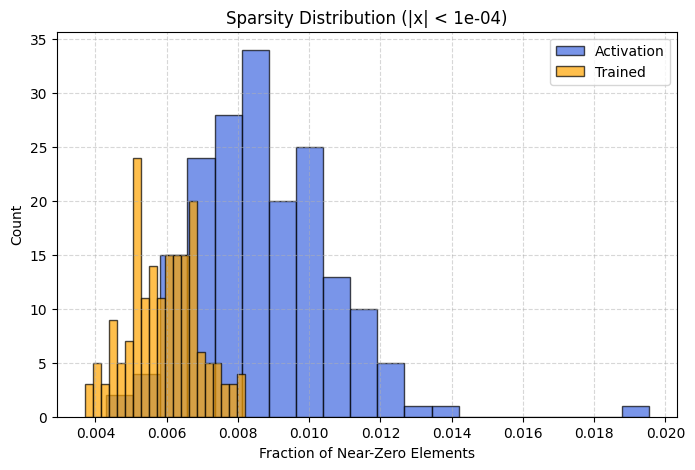

In [16]:
# Compare sparsity (fraction of near-zero elements) between trained and activation vectors


def compute_sparsity(arr: np.ndarray, threshold: float = 1e-5) -> float:
    """Compute the fraction of elements in arr with absolute value below threshold."""
    return np.mean(np.abs(arr) < threshold)

THRESHOLD = 1e-4

# Compute sparsity for each vector, then average
activation_sparsity = np.mean(
    [compute_sparsity(vec, THRESHOLD) for vec in activation_vectors_arr_normalized]
)
trained_sparsity = np.mean(
    [compute_sparsity(vec, THRESHOLD) for vec in trained_vectors_arr_normalized]
)

print(f"Mean sparsity (|x| < {THRESHOLD:.0e}):")
print(f"  Activation vectors: {activation_sparsity:.4f}")
print(f"  Trained vectors:    {trained_sparsity:.4f}")

# Plot histogram of sparsity across all vectors
activation_sparsity_all = [
    compute_sparsity(vec, THRESHOLD) for vec in activation_vectors_arr_normalized
]
trained_sparsity_all = [compute_sparsity(vec, THRESHOLD) for vec in trained_vectors_arr_normalized]

plt.figure(figsize=(8, 5))
plt.hist(
    activation_sparsity_all,
    bins=20,
    alpha=0.7,
    label="Activation",
    color="royalblue",
    edgecolor="black",
)
plt.hist(
    trained_sparsity_all,
    bins=20,
    alpha=0.7,
    label="Trained",
    color="orange",
    edgecolor="black",
)
plt.title(f"Sparsity Distribution (|x| < {THRESHOLD:.0e})")
plt.xlabel("Fraction of Near-Zero Elements")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
